# Analysis of SEIRX model runs for vaccination prevalence

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import analysis_functions as af
import seaborn as sns

In [2]:
language = 'english'
vaccination_ratios = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

## Mappings of variables to plot labels

Since these plots were also used to advise Austrian decision makers, we provide plot label mappings to German for easier communication of results.

In [3]:
# English
if language == 'english':
    metric_name_map = {'infected_residents_mean':'follow-up cases residents (mean)',
                       'infected_residents_median':'follow-up cases residends (median)',
                       'infected_residents_0.90':'follow-up cases residents (90th percentile)',
                       'R0_mean':'$R_0$',
                       'R0_mean':'$R_0$'}

    index_case_map = {'employee':'index case employee',
                      'resident':'index case resident'}
    xlabel = 'vaccinated employees'
    ylabel = 'vaccinated residents'

# German
if language == 'german':
    metric_name_map = {'infected_residents_mean':'Folgefälle BewohnerInnen (Mittelwert)',
                       'infected_residents_median':'Folgefälle BewohnerInnen (Median)',
                       'infected_residents_0.90':'Folgefälle BewohnerInnen (90. Percentile)',
                       'R0_mean':'$R_0$',
                       'R0_mean':'$R_0$'}

    index_case_map = {'employee':'kein Besuch (Indexfall MitarbeiterIn)',
                      'resident':'Besuch (Indexfall BewohnerIn)'}
    xlabel = 'geimpfte MitarbeiterInnen'
    ylabel = 'geimpfte BewohnerInnen'


## Analysis B.1.1.7

### Data loading and wrangling

In [136]:
res_path = '../data/simulation_results'
dst_path = '../plots'
N_runs = 5000
sim_name = 'simulations_vaccination_rate_UK_variant_{}.csv'.format(N_runs)

In [137]:
data = pd.read_csv(join(res_path, sim_name))

data = data.set_index(['index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio'])

### Plot heatmap

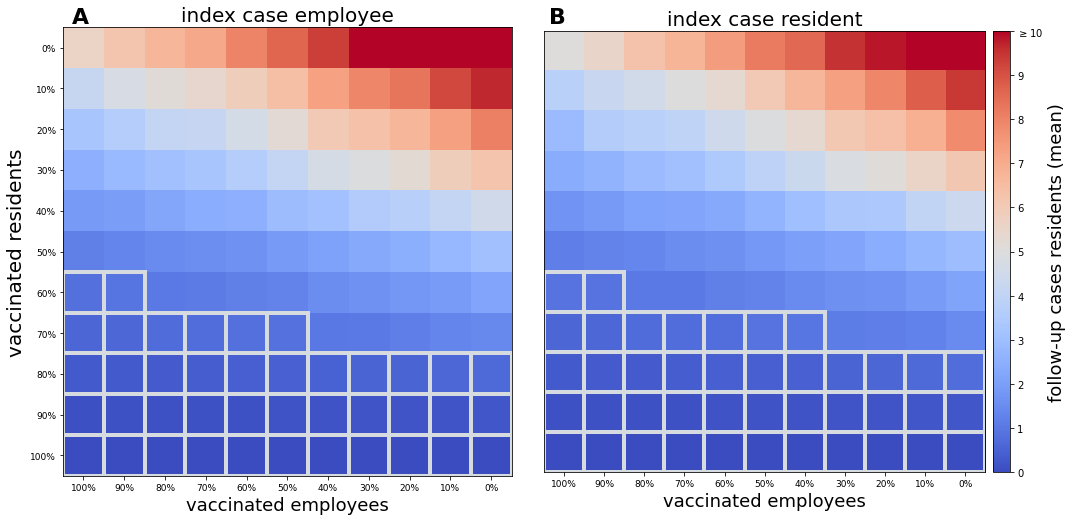

In [138]:
metric = 'infected_residents_mean'

# figure layout & axis setup
fig, axes = plt.subplots(1, 2, figsize=(15, 9))

vmin=0
vmax=10
vstep=1

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode, ax in zip([0, 1], ['employee', 'resident'], axes):
    
    ax.set_title(index_case_map[index_case_mode], fontsize=20)
        
    # set flag to set axis ticks only for heatmaps at the boundaries of 
    # the figure
    xticks = True
    yticks = False
    if i == 0:
        yticks = True

    # plot heatmap of the scenario
    img = af.get_image(data, index_case_mode, vaccination_ratios, metric)
    if index_case_mode == 'resident':
        # if a resident is the index case, we need to subtract 1 from the
        # number of infected residents, to calculate the "outbreak size",
        # which is defined as the number of FOLLOW-UP cases, given an index
        # case
        img = img - 1
    img_plot = af.plot_heatmap(ax, img,
            ['{:1.0f}%'.format(100*i) for i in vaccination_ratios],
            vmin, vmax, xticks, yticks, xlabel, ylabel)
    
    mask = np.where(img < 1, 1, 0)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if mask[i, j]:
                rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, color='g',
                                alpha=1, fill=False, ec='#D6DBDF', lw=4)
                ax.add_patch(rect)
            
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(20)
        
# colorbar
divider = make_axes_locatable(axes[1])
cbar_ax = divider.append_axes('right', size='4%', pad=0.1)

norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                        ticks=np.arange(vmin, vmax + 1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=18)      

# dummy axis to preserve spacing
divider = make_axes_locatable(axes[0])
cbar_ax = divider.append_axes('right', size='4%', pad=0.0)
cbar_ax.set_axis_off()

fig.text(0.07, 0.8525, 'A', fontweight='bold', fontsize=22)
fig.text(0.512, 0.8525, 'B', fontweight='bold', fontsize=22)

plt.tight_layout()

plt.savefig('../plots/vaccinations_UK_variant_{}.pdf'.format(language[0:3]))
plt.savefig('../plots/vaccinations_UK_variant_{}.png'.format(language[0:3]))

### Plot employee vaccination

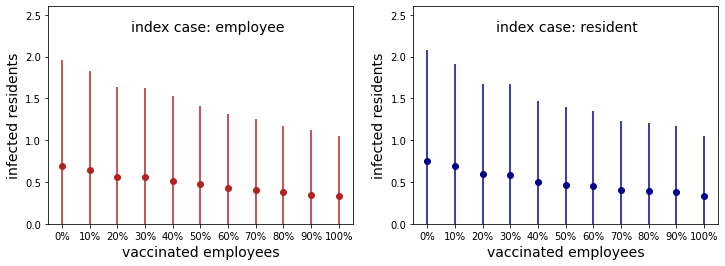

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = ['FireBrick', 'DarkBlue']

for index_case, ax, color in zip(index_cases, axes, colors):
    subset = data.loc[index_case, :, 0.8].copy()
    if index_case == 'resident':
        subset['infected_residents_mean'] -= 1
    ax.errorbar(subset.index.get_level_values('employee_vaccination_ratio') * 100, 
                subset['infected_residents_mean'], color=color,
                yerr=subset['infected_residents_std'], fmt='o')
    
    ax.text(25, 2.3, 'index case: {}'.format(index_case), fontsize=14)
    ax.set_ylim(0, 2.6)
    ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5])
    xticks = range(0, 101, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{}%'.format(i) for i in xticks])
    ax.set_xlabel('vaccinated employees', fontsize=14)
    ax.set_ylabel('infected residents', fontsize=14)
    #ax.plot([-2, 102], [0.5, 0.5], '--', color='grey')
    
plt.savefig('../plots/employee_vaccination_rate_UK_variant_{}.pdf'.format(language[0:3]))
plt.savefig('../plots/employee_vaccination_rate_UK_variant_{}.png'.format(language[0:3]))

### Outbreak sizes

#### Employee 50%, resident 0%

In [140]:
mean = data.loc['employee', 0.5, 0.0]['infected_residents_mean']
std = data.loc['employee', 0.5, 0.0]['infected_residents_std']
print('{} +- {}'.format(mean, std))

8.5944 +- 9.59044753787827


In [141]:
mean = data.loc['resident', 0.5, 0.0]['infected_residents_mean'] - 1
std = data.loc['resident', 0.5, 0.0]['infected_residents_std']
print('{} +- {}'.format(mean, std))

8.1954 +- 9.225911463289991


#### Employee 0%, resident 50%

In [142]:
mean = data.loc['employee', 0.0, 0.5]['infected_residents_mean']
std = data.loc['employee', 0.0, 0.5]['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.0936 +- 4.16392923827246


In [143]:
mean = data.loc['resident', 0.0, 0.5]['infected_residents_mean'] - 1
std = data.loc['resident', 0.0, 0.5]['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.995 +- 4.013950343423781


#### Employee 0%, resident 90%

In [148]:
mean = data.loc['employee', 0.0, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.0, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.2512 +- 0.570055745265796


In [149]:
mean = data.loc['resident', 0.0, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.0, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.264 +- 0.5919240448021713


#### Employee 50%, resident 90%

In [144]:
mean = data.loc['employee', 0.5, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.5, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.168 +- 0.4580589084306936


In [145]:
mean = data.loc['resident', 0.5, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.5, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.17599999999999993 +- 0.4628896773213614


#### Employee 90%, resident 90%

In [146]:
mean = data.loc['employee', 0.9, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.9, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1228 +- 0.3732934899056253


In [147]:
mean = data.loc['resident', 0.9, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.9, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.13139999999999996 +- 0.391618070245218


## Analysis wild type

### Data loading and wrangling

In [121]:
res_path = '../data/simulation_results'
dst_path = '../plots'
N_runs = 5000
sim_name = 'simulations_vaccination_rate_{}.csv'.format(N_runs)

In [122]:
data = pd.read_csv(join(res_path, sim_name))

data = data.set_index(['index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio'])

### Plot heatmap

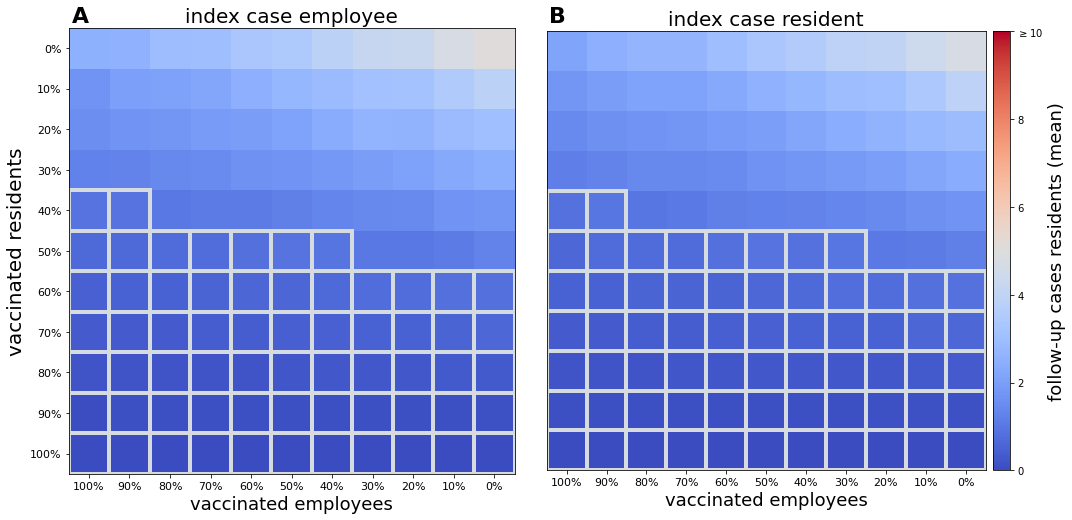

In [123]:
metric = 'infected_residents_mean'

# figure layout & axis setup
fig, axes = plt.subplots(1, 2, figsize=(15, 9))

vmin=0
vmax=10
vstep=2

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode, ax in zip([0, 1], ['employee', 'resident'], axes):
    
    ax.set_title(index_case_map[index_case_mode], fontsize=20)
        
    # set flag to set axis ticks only for heatmaps at the boundaries of 
    # the figure
    xticks = True
    yticks = False
    if i == 0:
        yticks = True

    # plot heatmap of the scenario
    img = af.get_image(data, index_case_mode, vaccination_ratios, metric)
    if index_case_mode == 'resident':
        # if a resident is the index case, we need to subtract 1 from the
        # number of infected residents, to calculate the "outbreak size",
        # which is defined as the number of FOLLOW-UP cases, given an index
        # case
        img = img - 1
    img_plot = af.plot_heatmap(ax, img,
            ['{:1.0f}%'.format(100*i) for i in vaccination_ratios],
            vmin, vmax, xticks, yticks, xlabel, ylabel,ticklabel_fontsize=11)
    
    mask = np.where(img < 1, 1, 0)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if mask[i, j]:
                rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, color='g',
                                alpha=1, fill=False, ec='#D6DBDF', lw=4)
                ax.add_patch(rect)
                
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(20)
        
# colorbar
divider = make_axes_locatable(axes[1])
cbar_ax = divider.append_axes('right', size='4%', pad=0.1)

norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                        ticks=np.arange(vmin, vmax + 1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=18)      

# dummy axis to preserve spacing
divider = make_axes_locatable(axes[0])
cbar_ax = divider.append_axes('right', size='4%', pad=0.0)
cbar_ax.set_axis_off()

fig.text(0.07, 0.8525, 'A', fontweight='bold', fontsize=22)
fig.text(0.512, 0.8525, 'B', fontweight='bold', fontsize=22)

plt.tight_layout()

plt.savefig('../plots/vaccinations_{}.pdf'.format(language[0:3]))
plt.savefig('../plots/vaccinations_{}.png'.format(language[0:3]))

### Plot employee vaccination

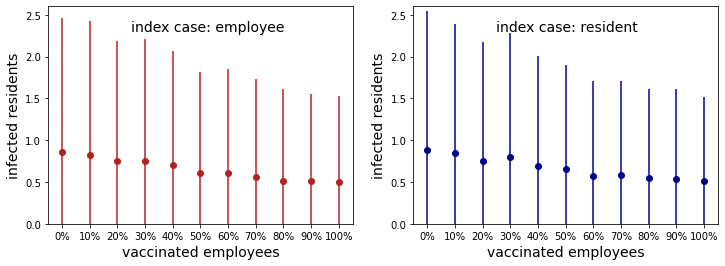

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = ['FireBrick', 'DarkBlue']

for index_case, ax, color in zip(index_cases, axes, colors):
    subset = data.loc[index_case, :, 0.6].copy()
    if index_case == 'resident':
        subset['infected_residents_mean'] -= 1
    ax.errorbar(subset.index.get_level_values('employee_vaccination_ratio') * 100, 
                subset['infected_residents_mean'], color=color,
                yerr=subset['infected_residents_std'], fmt='o')
    
    ax.text(25, 2.3, 'index case: {}'.format(index_case), fontsize=14)
    ax.set_ylim(0, 2.6)
    ax.set_yticks([0, 0.5, 1, 1.5, 2.0, 2.5])
    xticks = range(0, 101, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{}%'.format(i) for i in xticks])
    ax.set_xlabel('vaccinated employees', fontsize=14)
    ax.set_ylabel('infected residents', fontsize=14)
    #ax.plot([-2, 102], [0.5, 0.5], '--', color='grey')
    
plt.savefig('../plots/employee_vaccination_rate_{}.pdf'.format(language[0:3]))
plt.savefig('../plots/employee_vaccination_rate_{}.png'.format(language[0:3]))

### Outbreak sizes

#### Employee 50%, resident 0%

In [18]:
mean = data.loc['employee', 0.5, 0.0]['infected_residents_mean']
std = data.loc['employee', 0.5, 0.0]['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.4626 +- 5.270043255152868


In [19]:
mean = data.loc['resident', 0.5, 0.0]['infected_residents_mean'] - 1
std = data.loc['resident', 0.5, 0.0]['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.3242000000000003 +- 4.981009581529658


#### Employee 0%, resident 50%

In [20]:
mean = data.loc['employee', 0.0, 0.5]['infected_residents_mean']
std = data.loc['employee', 0.0, 0.5]['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.3162 +- 2.290953350343627


In [21]:
mean = data.loc['resident', 0.0, 0.5]['infected_residents_mean'] - 1
std = data.loc['resident', 0.0, 0.5]['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.2233999999999998 +- 2.115936643091072


#### Employee 50%, resident 90%

In [22]:
mean = data.loc['employee', 0.5, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.5, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0922 +- 0.3176780506562796


In [23]:
mean = data.loc['resident', 0.5, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.5, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.09699999999999998 +- 0.3193922389170658


#### Employee 90%, resident 90%

In [24]:
mean = data.loc['employee', 0.9, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.9, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.079 +- 0.2972821476898117


In [25]:
mean = data.loc['resident', 0.9, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.9, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.08679999999999999 +- 0.3106204388178638
